### Step 0 : Init RoboFeeder Env
This cell sets up the environment for the RoboFeeder simulation by importing necessary modules and configuring the Python path.

In [ ]:
import os 
dir = os.getcwd()
if 'examples' in dir:
    os.chdir(os.getcwd().split('examples')[0])
else:
    print("please set the working directory to the root of the gym4ReaL repository")

# check if the current working directory is the root of the gym4ReaL repository
os.getcwd()

'/home/edge/Desktop/gym4ReaL'

### Step 1 : Import Required Modules
This cell imports the necessary modules and updates the system path to include the gym4ReaL repository. It also imports the robot simulator and matplotlib for visualization purposes.

In [2]:
import sys
sys.path.append(os.getcwd())  # <-- path to the *parent* of gym4real
import os
import gymnasium as gym
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

import gym4real.envs.robofeeder as rf
from gym4real.algorithms.robofeeder import baseline


### Step 2 : Load Pretrained Agent and Setup Action Mapping
This cell sets up the ONNX runtime session for the pretrained PPO agent used in the RoboFeeder environment. It also defines the action index mapping for interpreting the agent's output.


In [4]:
current_dir = os.path.dirname(rf.__file__)
# Load the object detection network
pretrained_ppo_dir = os.path.join(current_dir, "utils", "Pretrained/")

# Init the ONNX runtime session
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
pretrained_agent = ort.InferenceSession(pretrained_ppo_dir + 'robofeeder-planning.onnx',providers=providers)
# baseline_agent = baseline.Baseline_picking()

# index dictionary for the action space
index_dict = {
    0:'Reset',
    1:'First',
    2:'Second',
    3:'Third',
}

### Step 3 : Test Simulator
import the simulator configuration file to pass the required parameters to run. 
Relevant parameters to adapt:

#### ObjectToPick
    NUMBER_OF_OBJECTS: 1           # (int) Number of objects to pick
    SHUFFLE_OBJECTS: True          # (bool) Shuffle object positions at reset
    OBJ_CORRECT_ORIENTATION: True  # (bool) Ensure objects have correct orientation

#### Simulator Setting
    IS_SIMULATION_REAL_TIME: False   # (bool) Run simulation in real time
    IS_SIMULATION_SHOWED: True       # (bool) Show simulation window
    IS_SIMULATION_RECORD: False      # (bool) Record simulation video
    RECORD_FOLDER : "." # (str) Folder to save recorded videos

In [5]:
import shutil

# Copy the default configuration file to a new editable file
default_config_file = os.getcwd() + "/gym4real/envs/robofeeder/configuration.yaml"
config_file = os.getcwd() + "/examples/robofeeder/notebooks/configuration_editable.yaml"
shutil.copy(default_config_file, config_file)

'/home/edge/Desktop/gym4ReaL/examples/robofeeder/notebooks/configuration_editable.yaml'


### Step 4 : Initialize the RoboFeeder Environment
This cell creates an instance of the RoboFeeder environment using the specified configuration file and resets the environment to obtain the initial observation.


In [6]:
env = gym.make('gym4real/robofeeder-planning', config_file=config_file)
current_obs,_ = env.reset()

/home/edge/Desktop/edgegym/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(



### Step 5 : Visualize Observations and Take Actions

-  Defines the `printobs` function to visualize the current observations from the RoboFeeder environment. It displays each camera view with its corresponding action and center coordinates.

-  Demonstrates how to use the pretrained agent to select and perform an action in the environment. It visualizes the observations before and after the action, prints the chosen action, and displays the reward and completion status.


In [9]:
def printobs(env,title):
    plt.figure(figsize=(10, 5))
    for i in range(env.unwrapped.IMAGE_NUM):
        ax = plt.subplot(1, env.unwrapped.IMAGE_NUM, i + 1)
        ax.imshow(env.unwrapped.current_obs[i],cmap=plt.cm.gray)
        ax.title.set_text("Action "+str(i + 1)+" - "+str(env.unwrapped.obsCenter[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

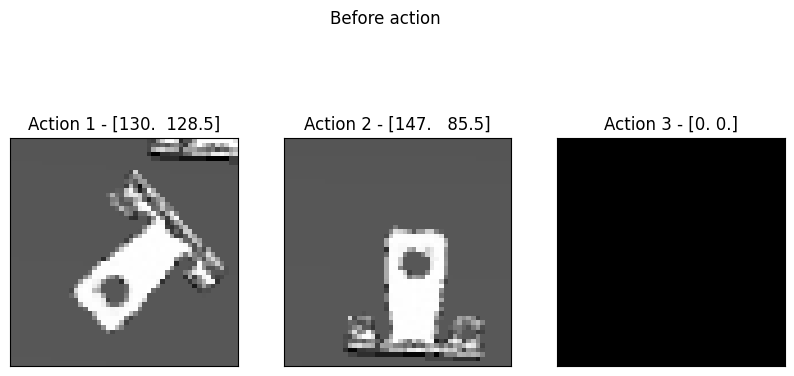

pretrained agent action
Object to pick: First


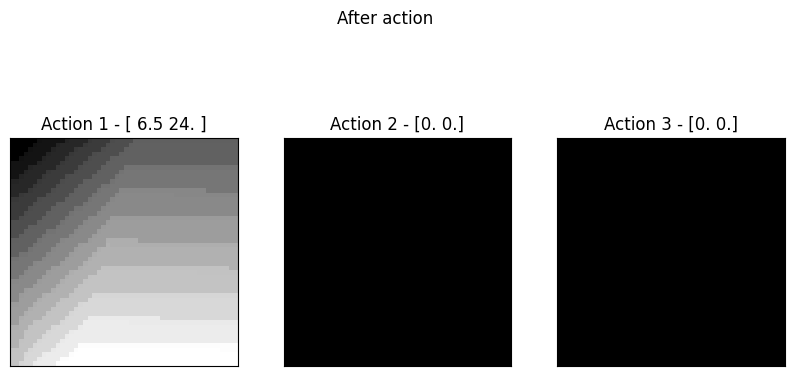

done: False
reward: 1 



In [10]:
# perform an action with pretrained agent   
# current_obs,_ = env.reset()
printobs(env,"Before action")
action = pretrained_agent.run(None, {"input": np.expand_dims(current_obs,axis=0)})[0][0]
print("pretrained agent action")
print(f"Object to pick: {index_dict[action]}")
current_obs,rew,done,_,_ = env.step(action)

printobs(env,"After action")

print("done:",done) 
print("reward:",rew,"\n")
if(done): env.reset()

### Step 6: The baseline agent

-  Initializes the baseline planning agent for comparison with the pretrained agent.

-  Shows how to use the baseline agent to select and perform an action in the environment. Similar to the pretrained agent, it visualizes the observations, prints the chosen action, and displays the reward and completion status.

In [11]:
baseline_agent = baseline.Baseline_planning(env.action_space)

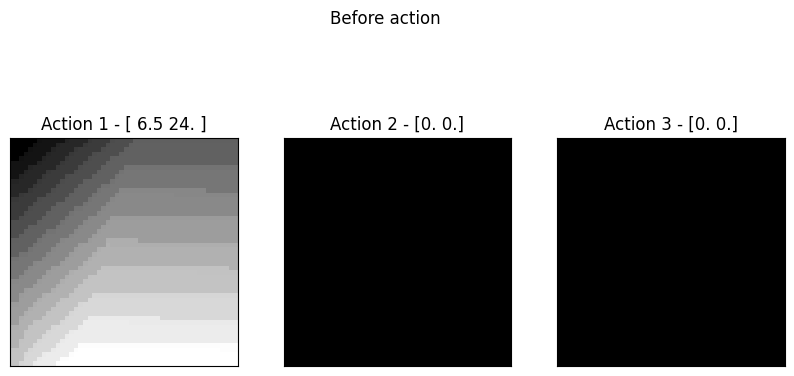

pretrained agent action
Object to pick: Reset


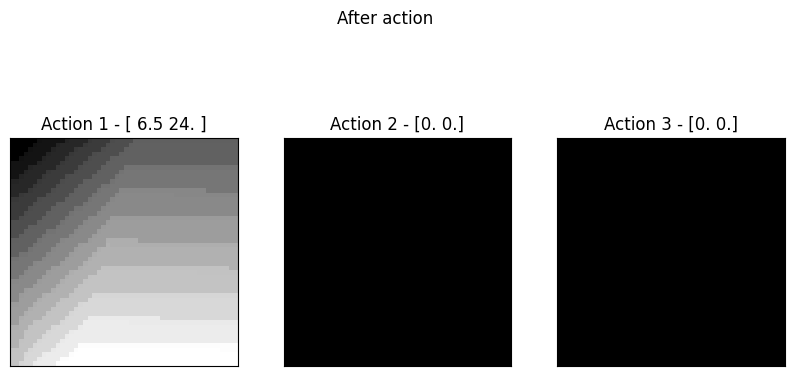

done: True
reward: 0 



In [12]:
# perform an action with baseline agent   

# perform an action with pretrained agent   
# current_obs,_ = env.reset()
printobs(env,"Before action")
action = baseline_agent.act()
print("pretrained agent action")
print(f"Object to pick: {index_dict[action]}")
current_obs,rew,done,_,_ = env.step(action)

printobs(env,"After action")

print("done:",done) 
print("reward:",rew,"\n")
if(done): env.reset()

### Step 7: Resetting the Environment

This cell resets the RoboFeeder environment to start a new cycle. It obtains a new observation and ensures the environment is ready for further actions.


In [ ]:
# Reset the environment to start a new cycle
current_obs, _ = env.reset()
print("Environment has been reset. New observation obtained.")